In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import necessary Libraries

In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import os

In [ ]:
# Specify Image and Captions Paths

In [31]:
image_dataset_path = r'/content/drive/MyDrive/Flickr_8k_Dataset/Images'
caption_dataset_path = r'/content/drive/MyDrive/Flickr_8k_Dataset/captions.txt'

In [ ]:
# Just Check with an Image, If it is loaded or not

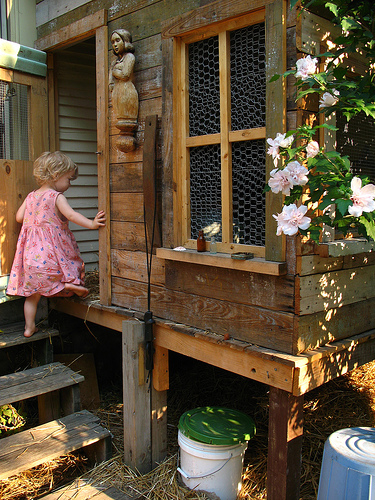

In [3]:
from IPython.display import Image
Image(r'/content/drive/MyDrive/Flickr_8k_Dataset/Images/1000268201_693b08cb0e.jpg')

In [ ]:
# Load the Caption file

In [32]:
def load_caption_file(path):

    # dictionary to store captions
    captions_dict = {}

    # iterate through the file
    for caption in open(path):

        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)

        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text

    return captions_dict

# call the function
captions_dict = load_caption_file(caption_dataset_path)

In [ ]:
# Caption Data Preprocessing

In [33]:
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [34]:
print('"' + list(new_captions_dict.keys())[1] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[1]])

"1000268201_693b08cb0e" : startseq child in pink dress is climbing up set of stairs in an entry way endseq


In [35]:
len(new_captions_dict)

8092

In [ ]:
# Caption Images List

In [36]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]

In [37]:
caption_images_list[0]

'2354540393_a149722680'

In [38]:
len(caption_images_list)

2223

In [ ]:
# Divide data into Train, Test and Validate data

In [55]:
train_validate_images = caption_images_list[0:2213]

In [56]:
test_images = caption_images_list[2213:2223]
test_images

['1244485675_822e6efe60',
 '124195430_d14028660f',
 '1253275679_e955fb7304',
 '124881487_36e668145d',
 '1248357227_2b4175fc39',
 '1245022983_fb329886dd',
 '124972799_de706b6d0b',
 '127490019_7c5c08cb11',
 '1277185009_06478dd457',
 '1262454669_f1caafec2d']

In [ ]:
# Extracting Image Features with VGG16

In [41]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()

    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # summarize
    print(model.summary())

    # extract features from each photo
    features = dict()

    for name in image_keys:

        # load an image from file
        filename = directory + '/' + name + '.jpg'

        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        image = preprocess_input(image)

        # get features
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = name.split('.')[0]

        # store feature
        features[image_id] = feature

#         print('>%s' % name)
    return features

In [ ]:
# extracting features for train validation

In [14]:
train_validate_features = extract_features(image_dataset_path, train_validate_images)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [42]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

2354540393_a149722680 : [[0.         0.04893884 0.         ... 0.         0.         0.        ]]


In [43]:
len(train_validate_features)

2223

In [44]:
from pickle import dump
dump(train_validate_features, open('./train_validate_features.pkl', 'wb'))

In [45]:
# load libraries
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [46]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():

    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):

         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

2223

In [47]:
list(train_validate_image_caption.values())[10]

'startseq brown and white dog is running through the snow endseq'

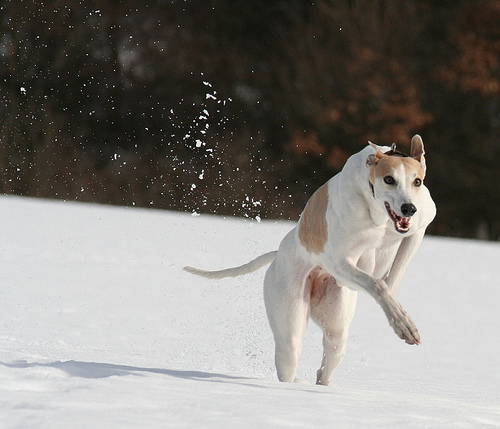

In [48]:
Image(image_dataset_path+'/'+list(train_validate_image_caption.keys())[10]+'.jpg')

In [49]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

def prepare_data(image_keys):

    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images
    for image in image_keys:

        # store the caption of that image
        caption = train_validate_image_caption[image]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)

    return np.array(x1), np.array(x2), np.array(y)

In [57]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:1213] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[1213:2123] )

In [58]:
len(train_x1)

12077

In [59]:
validate_x1.shape

(9371, 4096)

In [ ]:
# Modelling with LSTM

In [60]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256)(droplayer_)

# decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 29)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 29, 256)              574976    ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['input_4[0][0]']             
                                                                                            

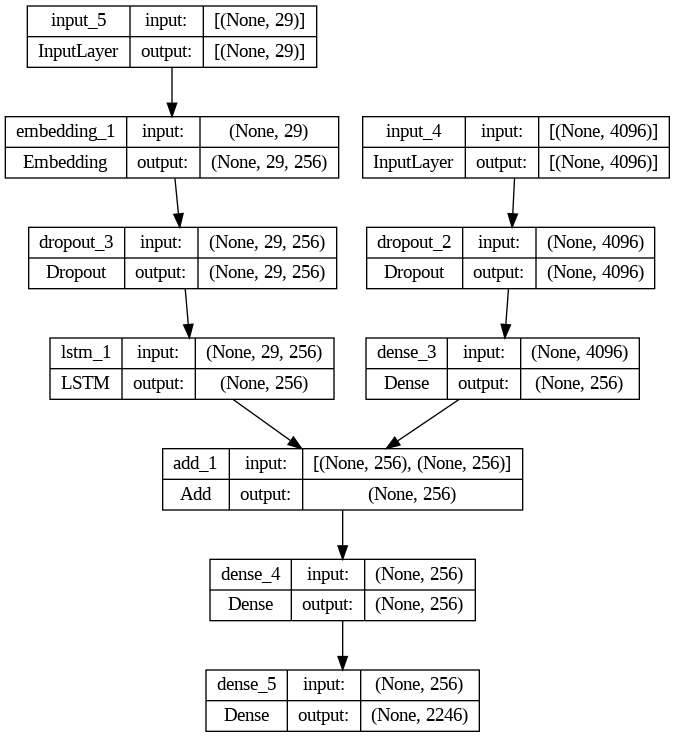

In [61]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# Reducing Overfitting

In [62]:
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

callbacks = [
             ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss') ]

In [63]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (12077, 4096)
shape of train_x2  (12077, 29)
shape of train_y  (12077, 2246)

shape of validate_x1  (9371, 4096)
shape of validate_x2  (9371, 29)
shape of validate_y  (9371, 2246)


In [65]:
# fit model
history = model.fit([train_x1, train_x2],
                    train_y,
                    verbose = 1,
                    epochs = 10,
                    callbacks = callbacks,
                    validation_data=([validate_x1, validate_x2], validate_y))

Epoch 1/10
378/378 [==============================] - 108s 287ms/step - loss: 4.6155 - val_loss: 5.1050
Epoch 2/10
378/378 [==============================] - 109s 288ms/step - loss: 4.1770 - val_loss: 5.0515
Epoch 3/10
378/378 [==============================] - 105s 278ms/step - loss: 3.8029 - val_loss: 5.0701
Epoch 4/10
378/378 [==============================] - 110s 291ms/step - loss: 3.4714 - val_loss: 5.1860
Epoch 5/10
378/378 [==============================] - 105s 278ms/step - loss: 3.1546 - val_loss: 5.3673
Epoch 6/10
378/378 [==============================] - 104s 277ms/step - loss: 2.8527 - val_loss: 5.5591
Epoch 7/10
378/378 [==============================] - 105s 279ms/step - loss: 2.5790 - val_loss: 5.8772
Epoch 8/10
378/378 [==============================] - 105s 278ms/step - loss: 2.3222 - val_loss: 6.2178
Epoch 9/10
378/378 [==============================] - 110s 290ms/step - loss: 2.1065 - val_loss: 6.4259
Epoch 10/10
378/378 [==============================] - 110s 292m

In [ ]:
# plot training loss and validation with respect to epochs

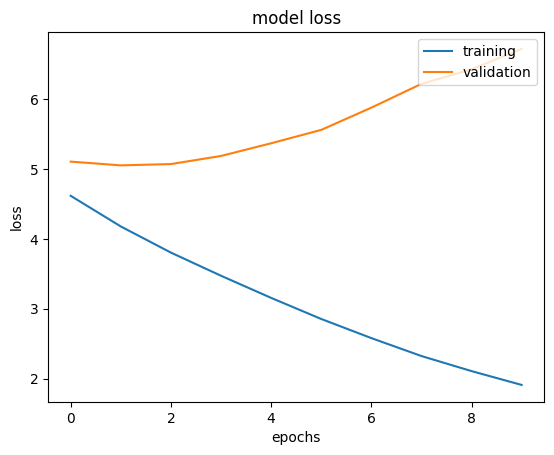

In [66]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [67]:
model.save('./latest_model.h5')

In [ ]:
#Evaluate the model

In [68]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [69]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [70]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 29)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 29, 256)              574976    ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['input_4[0][0]']             
                                                                                            

In [71]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def extract_feat(image_path):
    model = VGG16(weights='imagenet')
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    img = image.load_img(image_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features

In [ ]:
# Evaluate model on Test Data

In [74]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np

# Define the custom metric if not a built-in one
@tf.keras.utils.register_keras_serializable()
def mse(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

# Define the custom objects
custom_objects = {'mse': mse}

# Load the model with custom objects
modl = load_model(r'/content/latest_model.h5', custom_objects=custom_objects)

# Generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 29  # Update this to match the model's expected sequence length

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

for count in range(min(10, len(test_images))):  # Ensure loop does not go out of range
    photo = extract_feat('{}.jpg'.format(image_dataset_path + '/' + test_images[count]))

    # Generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()


1/1 [==============================] - 1s 777ms/step
Predicted caption ->  startseq

Actual caption ->  startseq boy in grey and white shirt looking at his reflection endseq
*********************************************************************



1/1 [==============================] - 1s 824ms/step
Predicted caption ->  startseq his and

Actual caption ->  startseq brown horse and black foal on the beach endseq
*********************************************************************



1/1 [==============================] - 1s 803ms/step
Predicted caption ->  startseq down the

Actual caption ->  startseq boy has his head down and is wearing shirt that says adhd endseq
*********************************************************************

1/1 [==============================] - 1s 810ms/step
Predicted caption ->  startseq

Actual caption ->  startseq man on bicycle riding down rocky hill endseq
*********************************************************************

1/1 [==============================] - 1s 803ms/step
Predicted caption ->  startseq to with

Actual caption ->  startseq kids play in the wooded area near the water endseq
*********************************************************************

1/1 [==============================] - 1s 1s/step
Predicted caption ->  startseq mountain the

Actual caption ->  startseq child in all pink is posing nearby stroller with buildings in the distance endseq
*****************************************************************